# Filtering signal in azimuthal space

Usually, diffraction signal presents a polar symmetry, this means all pixel with the same azimuthal angle (χ) have similar intensities. The best way to exploit this is to take the mean, what is called *azimuthal average*. But the average is very sensitive to outlier, like gaps, missing pixels, shadows, cosmic rays or reflection coming from larger crystallite. In this tutorial we will see two alternative ways to remove those unwanted signal and focus on the majority of pixels: **sigma clipping** and **median filtering**.

In [7]:
import os
os.environ["PYOPENCL_CTX"] = "0:1"

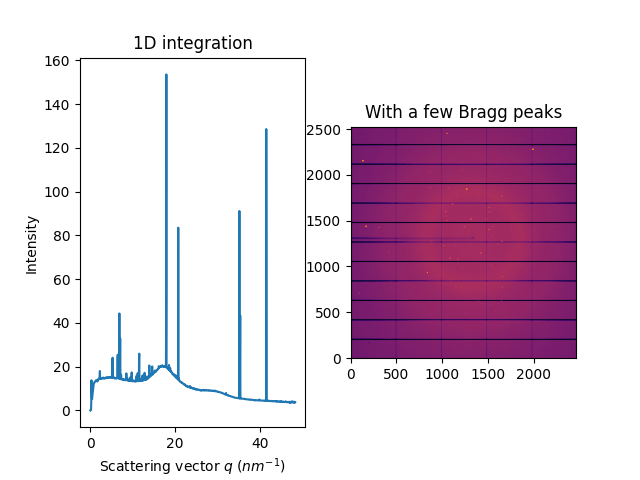

In [1]:
from matplotlib.pyplot import subplots
%matplotlib inline
from pyFAI.gui import jupyter
import numpy, fabio, pyFAI
from pyFAI import benchmark
from pyFAI.test.utilstest import UtilsTest

ai = pyFAI.load(UtilsTest.getimage("Pilatus6M.poni"))
img = fabio.open(UtilsTest.getimage("Pilatus6M.cbf")).data
fig, ax = subplots(1, 2)
jupyter.display(img, ax=ax[1])
jupyter.plot1d(ai.integrate1d(img, 1000), ax=ax[0])
ax[1].set_title("With a few Bragg peaks")
pass

## Azimuthal sigma-clipping

The idea is to discard pixels which look like outliers in the distribution of all pixels contributing to a single azimuthal bin.
It requires an error model like *poisson* but it has been proven to be better to use the variance in the given azimuthal ring.
All details are available in this publication: https://doi.org/10.1107/S1600576724011038 also available at https://doi.org/10.48550/arXiv.2411.09515 

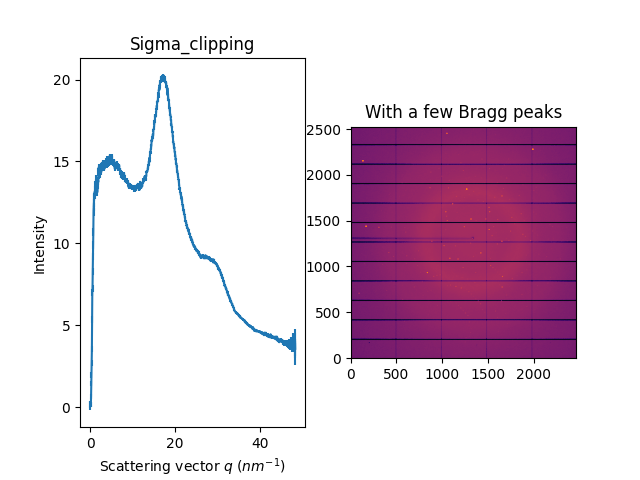

In [2]:
fig, ax = subplots(1, 2)
jupyter.display(img, ax=ax[1])
jupyter.plot1d(ai.sigma_clip(img, 1000, error_model="hybrid", method=("no", "csr", "cython")), ax=ax[0])
ax[1].set_title("With a few Bragg peaks")
ax[0].set_title("Sigma_clipping")
pass

Of course, *sigma-clip* takes several extra parameters like the number of iterations to perform, the cut-off, the error model, ... 
There are alo a few limitation: 
* The algorithm needs to be the CSR-sparse matrix multiplication: since several integration are needed, it makes no sense to use an histogram based algorithm.
* The algorithm is available with any implementation: Python (using scipy.saprse), Cython and OpenCL, and it runs just fine on GPU.
* Sigma-clipping is incompatible with any kind of pixel splitting: With pixel splitting, a single pixel can contribute to several azimuthal bins and discarding a pixel in one ring could disable it in the neighboring ring (or not, since bins are processed in parallel).

### Sigma-clipping performances:

In [3]:
method = ["no", "csr", "cython"]

In [6]:
%%time 
perfs_integrate_python = {}
perfs_integrate_cython = {}
perfs_integrate_opencl = {}
perfs_sigma_clip_python = {}
perfs_sigma_clip_cython = {}
perfs_sigma_clip_opencl = {}

for ds in pyFAI.benchmark.PONIS:
    ai = pyFAI.load(UtilsTest.getimage(ds))
    if ai.wavelength is None: ai.wavelength=1.54e-10
    img = fabio.open(UtilsTest.getimage(pyFAI.benchmark.datasets[ds])).data
    size = numpy.prod(ai.detector.shape)
    print(ds)
    print("     Cython")
    meth = tuple(method)
    nbin = max(ai.detector.shape)
    perfs_integrate_cython[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    perfs_sigma_clip_cython[size] = %timeit -o ai.sigma_clip(img, nbin, method=meth, error_model="azimuthal")
    print("     Python")
    meth = tuple(method[:2]+["python"])
    perfs_integrate_python[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    perfs_sigma_clip_python[size] = %timeit -o ai.sigma_clip(img, nbin, method=meth, error_model="azimuthal")

    print("     OpenCL")
    meth = tuple(method[:2]+["opencl"])
    perfs_integrate_opencl[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    perfs_sigma_clip_opencl[size] = %timeit -o ai.sigma_clip(img, nbin, method=meth, error_model="azimuthal")

Pilatus1M.poni
     cython
9.9 ms ± 731 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.3 ms ± 945 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
     python
10.8 ms ± 49.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


179 ms ± 663 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
     python
2.01 ms ± 167 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.91 ms ± 4.47 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Pilatus2M.poni
     cython
16.8 ms ± 94.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
23.9 ms ± 803 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
     python
27.8 ms ± 136 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


539 ms ± 2.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     python
4.66 ms ± 52.6 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
18.5 ms ± 25.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Eiger4M.poni
     cython
26.6 ms ± 184 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
43.4 ms ± 808 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
     python
54.1 ms ± 206 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


1.1 s ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     python
8.39 ms ± 22.6 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
34.8 ms ± 172 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Pilatus6M.poni
     cython
36.3 ms ± 178 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
50.7 ms ± 698 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
     python
80.3 ms ± 206 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


1.57 s ± 5.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     python
11.5 ms ± 52 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
39.3 ms ± 66.6 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Eiger9M.poni
     cython
74.7 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
120 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
     python
166 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


3.26 s ± 29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     python
18.6 ms ± 51.9 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
102 ms ± 195 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Mar3450.poni
     cython
69.3 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
114 ms ± 986 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
     python
176 ms ± 738 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


3.48 s ± 31.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     python
20.8 ms ± 265 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


102 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Fairchild.poni
     cython


RuntimeError: Scattering vector q cannot be calculated without knowing wavelength !!!

Text(0.5, 1.0, 'Performance of Sigma-clipping vs integrate')

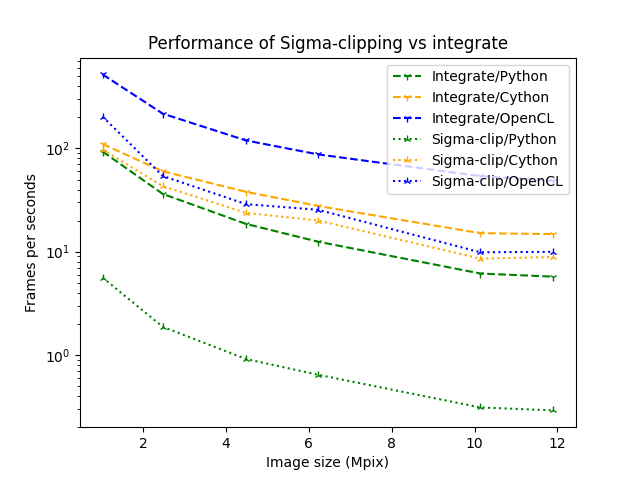

In [22]:
fig, ax = subplots()
ax.set_xlabel("Image size (Mpix)")
ax.set_ylabel("Frames per seconds")
sizes = numpy.array(list(perfs_integrate_python.keys()))/1e6
ax.plot(sizes, [1/i.best for i in perfs_integrate_python.values()], label="Integrate/Python", color='green', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perfs_integrate_cython.values()], label="Integrate/Cython", color='orange', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perfs_integrate_opencl.values()], label="Integrate/OpenCL", color='blue', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perfs_sigma_clip_python.values()], label="Sigma-clip/Python", color='green', linestyle='dotted', marker='2')
ax.plot(sizes, [1/i.best for i in perfs_sigma_clip_cython.values()], label="Sigma-clip/Cython", color='orange', linestyle='dotted', marker='2')
ax.plot(sizes, [1/i.best for i in perfs_sigma_clip_opencl.values()], label="Sigma-clip/OpenCL", color='blue', linestyle='dotted', marker='2')
ax.set_yscale("log")
ax.legend()
ax.set_title("Performance of Sigma-clipping vs integrate")

The biggest limitation of sigma-clipping is its incompatibility with pixel-splitting, feature needed when oversampling, i.e. taking many more points than the size of the diagonal of the image.
While oversampling is not recommended in general case (due to the cross-corelation between bins it creates), it can be a nessessary evil, especially when performing Rietveld refinement where 5 points per peaks are needed, resolution that cannot be obtained with the pixel-size/distance couple accessible by th experimental setup.

## Median filter in Azimuthal space

The idea is to sort all pixels contibuting to an azimuthal bin and to average out all pixel between the lower and upper quantile. 
When those two thresholds are at one half, this filter provides actually the median.
In order to compatible with pixel splitting, each pixel is duplicated as many times as it contributes to different bins.
After sorting pixels according to their normalization corrected signal, the cummulative sum of normalization is performed in order to detemine which pixel to average out.


In [38]:
ai = pyFAI.load(UtilsTest.getimage("Pilatus6M.poni"))
img = fabio.open(UtilsTest.getimage("Pilatus6M.cbf")).data

method = ["full", "csr", "cython"]
percentile=(40,60)
pol=0.99

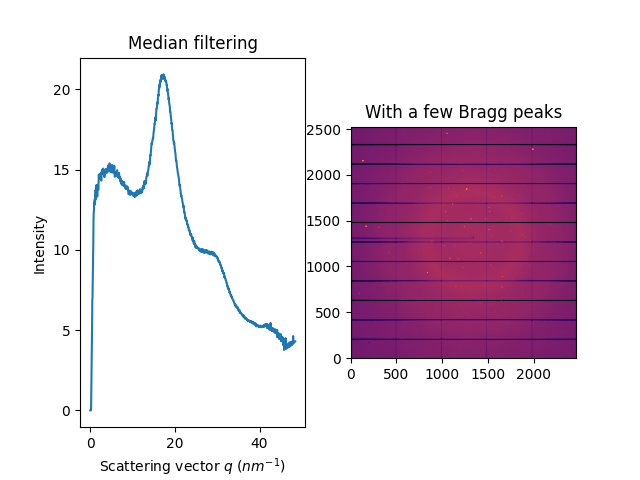

In [39]:
fig, ax = subplots(1, 2)
jupyter.display(img, ax=ax[1])
jupyter.plot1d(ai.medfilt1d_ng(img, 1000, method=method, percentile=percentile, polarization_factor=pol), ax=ax[0])
ax[1].set_title("With a few Bragg peaks")
ax[0].set_title("Median filtering")
pass

Unlike the *sigma-clipping*, this median filter does not equires any error model; but the computationnal cost induced by the sort is huge. In addition, the median is very sensitive and requires a good geometry and modelisation of the polarization.

In [40]:
%%time 
perf2_integrate_python = {}
perf2_integrate_cython = {}
perf2_integrate_opencl = {}
perf2_medfilt_python = {}
perf2_medfilt_cython = {}
perf2_medfilt_opencl = {}

for ds in pyFAI.benchmark.PONIS:
    ai = pyFAI.load(UtilsTest.getimage(ds))
    if ai.wavelength is None: ai.wavelength=1.54e-10
    img = fabio.open(UtilsTest.getimage(pyFAI.benchmark.datasets[ds])).data
    size = numpy.prod(ai.detector.shape)
    print(ds)
    print("     Cython")
    meth = tuple(method)
    nbin = max(ai.detector.shape)
    perf2_integrate_cython[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    perf2_medfilt_cython[size] = %timeit -o ai.medfilt1d_ng(img, nbin, method=meth)
    print("     Python")
    meth = tuple(method[:2]+["python"])
    perf2_integrate_python[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    perf2_medfilt_python[size] = %timeit -o ai.medfilt1d_ng(img, nbin, method=meth)

    print("     OpenCL")
    meth = tuple(method[:2]+["opencl"])
    perf2_integrate_opencl[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    perf2_medfilt_opencl[size] = %timeit -o ai.medfilt1d_ng(img, nbin, method=meth)

Pilatus1M.poni
     Cython
11.4 ms ± 6.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
27.4 ms ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
     Python
13.5 ms ± 49.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


1.04 s ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
2.15 ms ± 6.52 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
93.6 ms ± 299 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Pilatus2M.poni
     Cython
18.8 ms ± 855 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
92.8 ms ± 677 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
     Python
40 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


3.55 s ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
5.44 ms ± 4.75 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
385 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Eiger4M.poni
     Cython
29.8 ms ± 456 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
154 ms ± 3.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
     Python
80.6 ms ± 420 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


6.17 s ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
9.71 ms ± 12.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
732 ms ± 23.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Pilatus6M.poni
     Cython
43.7 ms ± 3.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
219 ms ± 5.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     Python
130 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


9.23 s ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
13.2 ms ± 59.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.06 s ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Eiger9M.poni
     Cython
67.7 ms ± 756 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
370 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     Python
216 ms ± 3.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


15.1 s ± 97.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
21.9 ms ± 596 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2 s ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mar3450.poni
     Cython
73 ms ± 781 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
393 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     Python
256 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


17.3 s ± 71.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
24.6 ms ± 44.3 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.35 s ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Fairchild.poni
     Cython
96.6 ms ± 793 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
417 ms ± 932 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
     Python
380 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


20.7 s ± 88.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
30.2 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.6 s ± 50.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
CPU times: user 16min 23s, sys: 15.3 s, total: 16min 38s
Wall time: 13min 5s


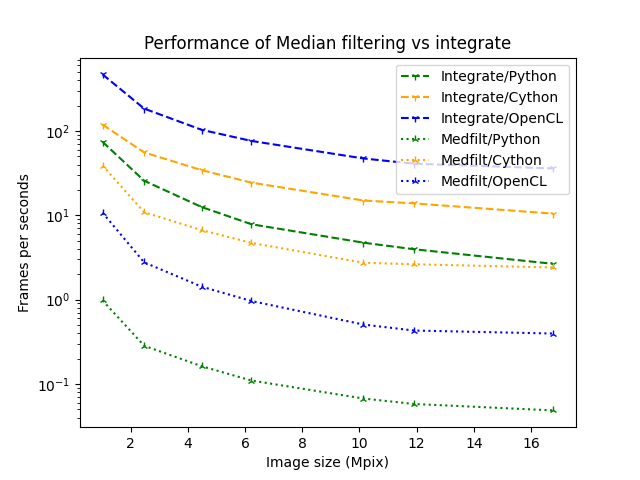

In [42]:
fig, ax = subplots()
ax.set_xlabel("Image size (Mpix)")
ax.set_ylabel("Frames per seconds")
sizes = numpy.array(list(perf2_integrate_python.keys()))/1e6
ax.plot(sizes, [1/i.best for i in perf2_integrate_python.values()], label="Integrate/Python", color='green', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perf2_integrate_cython.values()], label="Integrate/Cython", color='orange', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perf2_integrate_opencl.values()], label="Integrate/OpenCL", color='blue', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perf2_medfilt_python.values()], label="Medfilt/Python", color='green', linestyle='dotted', marker='2')
ax.plot(sizes, [1/i.best for i in perf2_medfilt_cython.values()], label="Medfilt/Cython", color='orange', linestyle='dotted', marker='2')
ax.plot(sizes, [1/i.best for i in perf2_medfilt_opencl.values()], label="Medfilt/OpenCL", color='blue', linestyle='dotted', marker='2')
ax.set_yscale("log")
ax.legend()
ax.set_title("Performance of Median filtering vs integrate")
pass

As one can see, the penalities are much larger for OpenCL than for Cython.

## Conclusion
*Sigma-clipping* and *median-filtering* are alternatives to azimuthal integration and offer the ability to reject outlier. They are mot more difficult to use but slightly slower owing to their greater complexity.